# Learning Auto-Punctuation by Reading Engadget Articles

## Overview

This project trains a bi-directional GRU to learn how to automatically punctuate a sentence by reading it character by character. The set of operation it learns include:
```
capitalization: <cap>
         comma:  ,
        period:  .
   dollar sign:  $
     semicolon:  ;
         colon:  :
  single quote:  '
  double quote:  "
  no operation: <nop>
```

## Setup and Considerations

The initial setup I began with was a single uni-direction GRU, with input domain [A-z0-9] and output domain of the ops listed above. My hope at that time was to simply train the RNN to learn correcponding operations. A few things jumped out of the experiment:

1. **Use bi-directional GRU.** with the uni-direction GRU, the network quickly learned capitalization of terms, but it had difficulties with single quote. In words like "I'm", "won't", there are simply too much ambiguity from reading only the forward part of the word. The network didn't have enough information to properly infer such punctuations.
    
    So I decided to change the uni-direction GRU to bi-direction GRU. The result is much better prediction for single quotes in concatenations.

    the network is still training, but the precision and recall of single quote is nowt close to 80%.
    
    This use of bi-directional GRU is standard in NLP processes. But it is nice to experience first-hand the difference in performance and training.
    
    A side effect of this switch is that the network now runs almost 2x slower. This leads to the next item in this list:
2. **Use the smallest model possible.** At the very begining, my input embeding was borrowed from the Shakespeare model, so the input space include both capital alphabet as well as lower-case ones. What I didn't realize was that I didn't need the capital cases because all inputs were lower-case. 
    
    So when the training became painfully slow after I switch to bi-directional GRU, I looked for ways to make the training faster. A look at the input embeding made it obvious that half of the embedding space wasn't needed. 

    Removing the lower case bases made the traing around 3x faster. This is a rough estimate since I also decided to redownload the data set at the same time on the same machine.
    
3. **Text formatting**. Proper formating of input text crawed from Engadget.com was crucial, especially because the occurrence of a lot of the puncuation was low and this is a character-level model. You can take a look at the crawed text inside [./engadget_data_tar.gz](./engadget_data_tar.gz). 

4. **Async and Multi-process crawing is much much faster**. I initially wrote the engadget crawer as a single threaded class. Because the python `requests` library is synchronous, the crawler spent virtually all time waiting for the `GET` requests.
    
    This could be made a *lot* faster by parallelizing the crawling, or use proper async pattern. 

    This thought came to me pretty late during the second crawl so I did not implement it. But for future work, parallel and async crawler is going to be on the todo list.

5. **Using Precision/Recall in a multi-class scenario**. The setup makes the reasonable assumption that each operation can only be applied mutually exclusively. The accuracy metric used here are **precision/recall** and the **F-score**, both commonly used in the literature<sup>1,</sup> <sup>2</sup>. The P/R and F-score are implemented according to wikipedia <sup>3,</sup> <sup>4</sup>.
    
    example accuracy output:
    ```
    Key: <nop>	Prec:  98.9%	Recall:  97.8%	F-Score:  98.4%
    Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
    Key: <cap>	Prec: 100.0%	Recall:  60.0%	F-Score:  75.0%
    Key:   .	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
    Key:   '	Prec:  66.7%	Recall: 100.0%	F-Score:  80.0%
    ```
    
6. **Hidden Layer initialization**: In the past I've found it was easier for the neural network to generate good results when both the training and the generation starts with a zero initial state. In this case because we are computing time limited, I zero the hidden layer at the begining of each file. 

## Data and Cross-Validation

The entire dataset is composed of around 50k blog posts from engadget. I randomly selected 49k of these as my training set, 50 as my validation set, and around 0.5k as my test set. The training is a bit slow on an Intel i7 desktop, averaging 1.5s/file depending on the length of the file. As a result, it takes about a day to go through the entire training set.

## Todo:
- [ ] execute test after training

## Done:
- [x] a generative demo
- [x] add validation (once an hour or so)
- [x] add accuracy metric, use precision/recall.
- [x] change to bi-directional GRU
- [x] get data
- [x] Add temperature to generator
- [x] add self-feeding generator
- [x] get training to work
- [x] use optim and Adam

## References
1: https://www.aclweb.org/anthology/D/D16/D16-1111.pdf  
2: https://phon.ioc.ee/dokuwiki/lib/exe/fetch.php?media=people:tanel:interspeech2015-paper-punct.pdf  
3: https://en.wikipedia.org/wiki/precision_and_recall  
4: https://en.wikipedia.org/wiki/F1_score  

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, num_flat_features

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output, HTML

import os

from bs4 import BeautifulSoup

In [2]:
def get_content(fn):
    with open(fn, 'r') as f:
        source = ""
        for line in f:
            source += line
    return source

In [3]:
_, _, files = list(os.walk("./engadget_data"))[0]
"number of files: ", len(files)

('number of files: ', 49531)

In [ ]:
def source_gen(path="./engadget_data", start=None, end=None):
    child, folders, files = list(os.walk(path))[0]
    for fn in files:
        if fn[0] is ".":
            pass
        else: 
            src = get_content("./engadget_data/" + fn)
            soup = BeautifulSoup(src, 'html.parser')
            src = soup.getText()
            yield fn, src
def train_gen():
    yield from source_gen(end=49000)
def validation_gen():
    yield from source_gen(start=49000, end=49050)
def test_gen():
    yield from source_gen(start=49050)

In [5]:
for fn, text in train_gen():
    print(text)
    break


 HTC is making a two-pronged attack on Windows Phone 8, and while it may not match up to the specs on its new flagship, the Windows Phone 8S by HTC (yes, that's the official moniker) has some charm all of its own. The screen is a pretty underwhelming Gorilla Glass-coated 4-inch WVGA LCD, with a similarly middleweight 5-megapixel camera peering out from the other side. Given that it's looking to be priced closer to the One V than the One S, we're not all that surprised. The phone itself is a good-looking slab, thanks to the breezy color schemes and while the build is certainly solid enough, we'd be hard-pressed to put it in league with the 8X, which felt at home in our hand from the start. The 8S is cocooned in a matte plastic finish, arriving in four different color options -- depending on carrier and territory.

 The two-tone color scheme, aside from a few color licks around the lens and ear piece, keeps the second color limited to the bottom edge and the detachable cap. This offers 

## Data Preparation

Here we build up generators for batches and take a quick look at the data. I collect all of the different characters that occurs in the data, and plot then ordered by the appearance frequency. It looks like some Japanese and Korean article got mixed in.

In [6]:
import math

In [7]:
def batch_gen(seq_length, source):
    s_l = len(source)
    b_n = math.ceil(s_l/seq_length)
    s_pad = source + " " * (b_n * seq_length - s_l)
    for i in range(b_n):
        yield s_pad[i*seq_length: (i+1)*seq_length]

In [ ]:
def get_chars():
    step = 0
    freq = {}
    keys = []
    for file_name, source in tqdm(source_gen()):

        for char in source:
            try:
                freq[char] += 1
            except KeyError:
                freq[char] = 1
                keys.append(char)
        #if step%10000 == 9999:
        #    print(str(step) + ": ln: " + str(len(keys)) + str(["".join(keys)]))
    
    return keys, freq
ks, freqs = get_chars()
HTML("<pre>" + "".join(ks) + "</pre>")

### Character Frequency

There is a long tail of characters that appears only once, mostly emoji's and CJK characters. 

In this project, we will just manually specify lowercase alphabets and numbers as out input domain (plus space and hyphen).

 etoainsrlhdcupmgfwyb,v.k-
'STA0P1MICxD2"BWEGN3OHRLFV5)(4Uzj9:q	867$X/KJY?;QZ[]&!–®™*%+=•_#·@£ €—é¥’{}‐ü|~α×°>à￼©^�\―”ö　“●…ー℠ó§ñ‟±­◦・ッ、：µ‖​


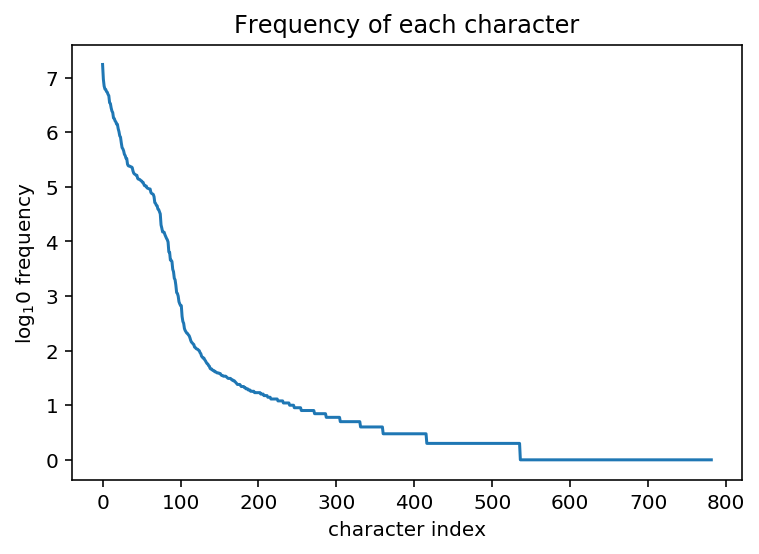

In [9]:
order = np.argsort([freqs[k] for k in ks])[::-1]
chars_ordered = "".join(np.array([k for k in ks])[order])
print(chars_ordered[:140])

plt.title('Frequency of each character')
plt.plot(np.array([math.log10(freqs[k]) for k in ks])[order])
plt.ylabel('$\log_10$ frequency')
plt.xlabel('character index')
plt.show()

### Output Domain

The output domain includes the following. The punctuation extraction made sure that strings like "I'm a boy" doesn't introduce conflict between the capitalization of the "i" and the single quote afterward.

```
capitalization: <cap>
         comma:  ,
        period:  .
   dollar sign:  $
     semicolon:  ;
         colon:  :
  single quote:  '
  double quote:  "
  no operation: <nop>
```

In [10]:
input_chars = list(" \nabcdefghijklmnopqrstuvwxyz01234567890")
output_chars = ["<nop>", "<cap>"] + list(".,;:?!\"'$")

In [11]:
class GruRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers=1, bi=False):
        super(GruRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = layers
        self.bi_mul = 2 if bi else 1
        
        self.encoder = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, self.layers, bidirectional=bi)
        self.decoder = nn.Linear(hidden_size * self.bi_mul, output_size)
        self.softmax = F.softmax
        
    def forward(self, x, hidden):
        #embeded = self.encoder(x)
        embeded = x
        #print(embeded.view(-1, 1, self.input_size).size())
        #print(hidden.size())
        gru_output, hidden = self.gru(embeded.view(-1, 1, self.input_size), hidden.view(self.layers * self.bi_mul, -1, self.hidden_size))
        #print(gru_output.size())
        output = self.decoder(gru_output.view(-1, self.hidden_size * self.bi_mul))
        return output, hidden
    
    def init_hidden(self, random=False):
        if random:
            return Variable(torch.randn(self.layers * self.bi_mul, self.hidden_size))
        else:
            return Variable(torch.zeros(self.layers * self.bi_mul, self.hidden_size)) 
"""
input_size = 105
hidden_size = 105
output_size = 105
layers = 2

gRNN = GruRNN(input_size, hidden_size, output_size, layers)

gRNN(Variable(torch.FloatTensor(10000, 105)),
     Variable(torch.FloatTensor(layers, 105)))"""

'\ninput_size = 105\nhidden_size = 105\noutput_size = 105\nlayers = 2\n\ngRNN = GruRNN(input_size, hidden_size, output_size, layers)\n\ngRNN(Variable(torch.FloatTensor(10000, 105)),\n     Variable(torch.FloatTensor(layers, 105)))'

In [12]:
class Engadget():
    def __init__(self, model, char2vec=None, output_char2vec=None):
        self.model = model
        if char2vec is None:
            self.char2vec = Char2Vec()
        else:
            self.char2vec = char2vec
            
        if output_char2vec is None:
            self.output_char2vec = self.char2vec
        else:
            self.output_char2vec = output_char2vec
            
        self.loss = 0
        self.losses = []
    
    def init_hidden_(self, random=False):
        self.hidden = model.init_hidden(random)
        return self
    
    def save(self, fn="GRU_Engadget.tar"):
        torch.save({
            "hidden": self.hidden, 
            "state_dict": model.state_dict(),
            "losses": self.losses
                   }, fn)
    
    def load(self, fn):
        checkpoint = torch.load(fn)
        self.hidden = checkpoint['hidden']
        model.load_state_dict(checkpoint['state_dict'])
        self.losses = checkpoint['losses']
    
    def setup_training(self, learning_rate):
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_hidden_()
        
    def reset_loss(self):
        self.loss = 0
        
    def forward(self, input_text, target_text):
        
        self.hidden = self.hidden.detach()
        
        self.optimizer.zero_grad()
        self.next_(input_text)
        target_vec = Variable(self.output_char2vec.char_code(target_text))
        self.loss += self.loss_fn(self.output, target_vec)
        
    def descent(self):
        if self.loss is 0:
            print(self.loss)
            print('Warning: loss is zero.')
            return
        
        self.loss.backward()
        self.optimizer.step()
        self.losses.append(self.loss.cpu().data.numpy())
        self.reset_loss()
    
    def embed(self, input_data):
        self.embeded = Variable(self.char2vec.one_hot(input_data))
        return self.embeded
        
    def next_(self, input_text):
        self.output, self.hidden = self.model(self.embed(input_text), self.hidden)
        return self
    
    def softmax_(self, temperature=0.5):
        self.softmax = self.model.softmax(self.output/temperature)
        return self
    
    def output_chars(self, start=None, end=None):
        indeces = torch.multinomial(self.softmax[start:end]).view(-1)
        return self.output_char2vec.vec2list(indeces)

In [13]:
def apply_punc(text_input, text_output):
    result = ""
    for char1, char2 in zip(text_input, text_output):
        if char2 == "<cap>":
            result += char1.upper()
        elif char2 == "<nop>":
            result += char1
        else:
            result += char2 + char1 
    return result


result = apply_punc("t s", ['<cap>', '<nop>', ','])
assert(result == "T ,s")

In [21]:
def extract_punc(string_input, input_chars, output_chars):
    input_source = []
    output_source = []
    input_length = len(string_input)
    i = 0
    while i < input_length:
        char = string_input[i]
        if char.isupper():
            output_source.append("<cap>")
            input_source.append(char.lower())
            
        if char in output_chars:
            output_source.append(char)
            if i < input_length - 1:
                input_source.append(string_input[i + 1])
            else:
                input_source.append(" ")
            i += 1
        
        if not char.isupper() and char not in output_chars and char in input_chars:
            input_source.append(char)
            output_source.append("<nop>")
        
        i += 1
    return input_source, output_source

i, o = extract_punc("ATI'd. I'm not sure if $10 is enough. ", input_chars, output_chars)
print(i)
print(o)
result = apply_punc("".join(i), o)
print(result)

['a', 't', 'i', 'd', ' ', 'i', 'm', ' ', 'n', 'o', 't', ' ', 's', 'u', 'r', 'e', ' ', 'i', 'f', ' ', '1', '0', ' ', 'i', 's', ' ', 'e', 'n', 'o', 'u', 'g', 'h', ' ']
['<cap>', '<cap>', '<cap>', "'", '.', '<cap>', "'", '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '$', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '.']
ATI'd. I'm not sure if $10 is enough. 


### Accuracy Metric

The accuracy metric is the standard precision/recall plus F-score. The implementation is bellow, referenced from wikipedia and two other papers.

In [15]:
from termcolor import cprint, colored as c

def inc(d, k):
    if k in d: d[k] += 1
    else: d[k] = 1
        
def precision_recall(output, target):
    
    assert len(output) == len(target)
    
    keys = []
    true_p = {}
    p = {}
    all_p = {}
    for i in range(len(output)):
    
        inc(all_p, target[i])
        inc(p, output[i])
        if target[i] == output[i]:
            inc(true_p, output[i])
        
    precision = {k: (true_p[k] if k in true_p else 0) / all_p[k] for k in all_p.keys()}
    
    recall = {k: (true_p[k] if k in true_p else 0) / p[k] for k in p.keys()}
    
    return precision, recall, {"true_p": true_p, "p": p, "all_p": all_p}

test_o = ['<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<cap>', '<cap>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>',
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<cap>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', "'", '<nop>', '<nop>', '<cap>', '<nop>', '<nop>', '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', "'", '<nop>', 
          '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>']
test_target = ['<nop>', '<nop>', ',', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<cap>', '<cap>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>',
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '.', '<nop>', 
               '<cap>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', "'", '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>',
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', ',', '<nop>', '<nop>',
               '<nop>', "'", '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', "'", '<nop>', '<nop>', 
               '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>']

def F_score(p, r):
    f_scores = {
        k: None if p[k] == 0 else (0 if r[k] == 0 else 2 /(1/p[k] + 1/r[k]) )
        for k in p
    }
    return f_scores
        

p, r, _ = precision_recall(test_o, test_target)
f = F_score(p, r)

for k in p.keys():
    cprint("Key: " + c(("  " + k)[-5:], 'red') + 
           "\tPrec: " + c("  {:.1f}".format(p[k] * 100)[-5:], 'green') + '%' + 
           "\tRecall: " + c("  {:.1f}".format((r[k] if k in r else 0) * 100)[-5:], 'green') + "%" + 
           "\tF-Score: " + ("  N/A" if f[k] is None else (c("  {:.1f}".format(f[k] * 100)[-5:], "green") + "%"))
          )
    
print('\n')
for k in _:
    print(k + ':\t' + str(_[k]))

Key: <nop>	Prec:  98.9%	Recall:  97.8%	F-Score:  98.4%
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
Key: <cap>	Prec: 100.0%	Recall:  60.0%	F-Score:  75.0%
Key:   .	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
Key:   '	Prec:  66.7%	Recall: 100.0%	F-Score:  80.0%


true_p:	{'<nop>': 181, '<cap>': 3, "'": 2}
p:	{'<nop>': 185, '<cap>': 5, "'": 2}
all_p:	{'<nop>': 183, ',': 2, '<cap>': 3, '.': 1, "'": 3}


In [16]:
def print_pc(o, target):
    p, r, _ = precision_recall(test_o, test_target)
    f = F_score(p, r)

    for k in p.keys():
        cprint("Key: " + c(("  " + k)[-5:], 'red') + 
               "\tPrec: " + c("  {:.1f}".format(p[k] * 100)[-5:], 'green') + '%' + 
               "\tRecall: " + c("  {:.1f}".format((r[k] if k in r else 0) * 100)[-5:], 'green') + "%" + 
               "\tF-Score: " + ("  N/A" if f[k] is None else (c("  {:.1f}".format(f[k] * 100)[-5:], "green") + "%"))
              )
    
        
def plot_progress(embeded, output, softmax, losses):
    fig = plt.figure(figsize=(16, 8))
    fig.subplots_adjust(hspace=0.0625)
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(embeded, cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    im = plt.imshow(output, interpolation="none")
    cb = plt.colorbar(im, fraction=0.08); cb.outline.set_linewidth(0)
    plt.subplot(133)
    plt.title("Softmax Output")
    im = plt.imshow(softmax, interpolation="none")
    cb = plt.colorbar(im, fraction=0.08); cb.outline.set_linewidth(0)
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.title('Training loss')
    plt.plot(losses, label="loss", linewidth=3, alpha=0.4)
    plt.show()

In [17]:
# torch.set_num_threads(8)

char2vec = Char2Vec(chars=input_chars, add_unknown=True)
output_char2vec = Char2Vec(chars = output_chars)
input_size = char2vec.size 
output_size = output_char2vec.size

print("input_size is: " + str(input_size) + "; ouput_size is: " + str(output_size))
hidden_size = input_size
layers = 1

model = GruRNN(input_size, hidden_size, output_size, layers=layers, bi=True)
egdt = Engadget(model, char2vec, output_char2vec)
#egdt.load('./data/Gru_Engadget_1_layer_bi_narrow.tar')

input_size is: 40; ouput_size is: 11


In [18]:
learning_rate = 2e-3
egdt.setup_training(learning_rate)

## Training

The training below initializes the hidden layer at the beginning of each file. I believe this makes it more consistent, and easier for the network to converge.

Epoch 0


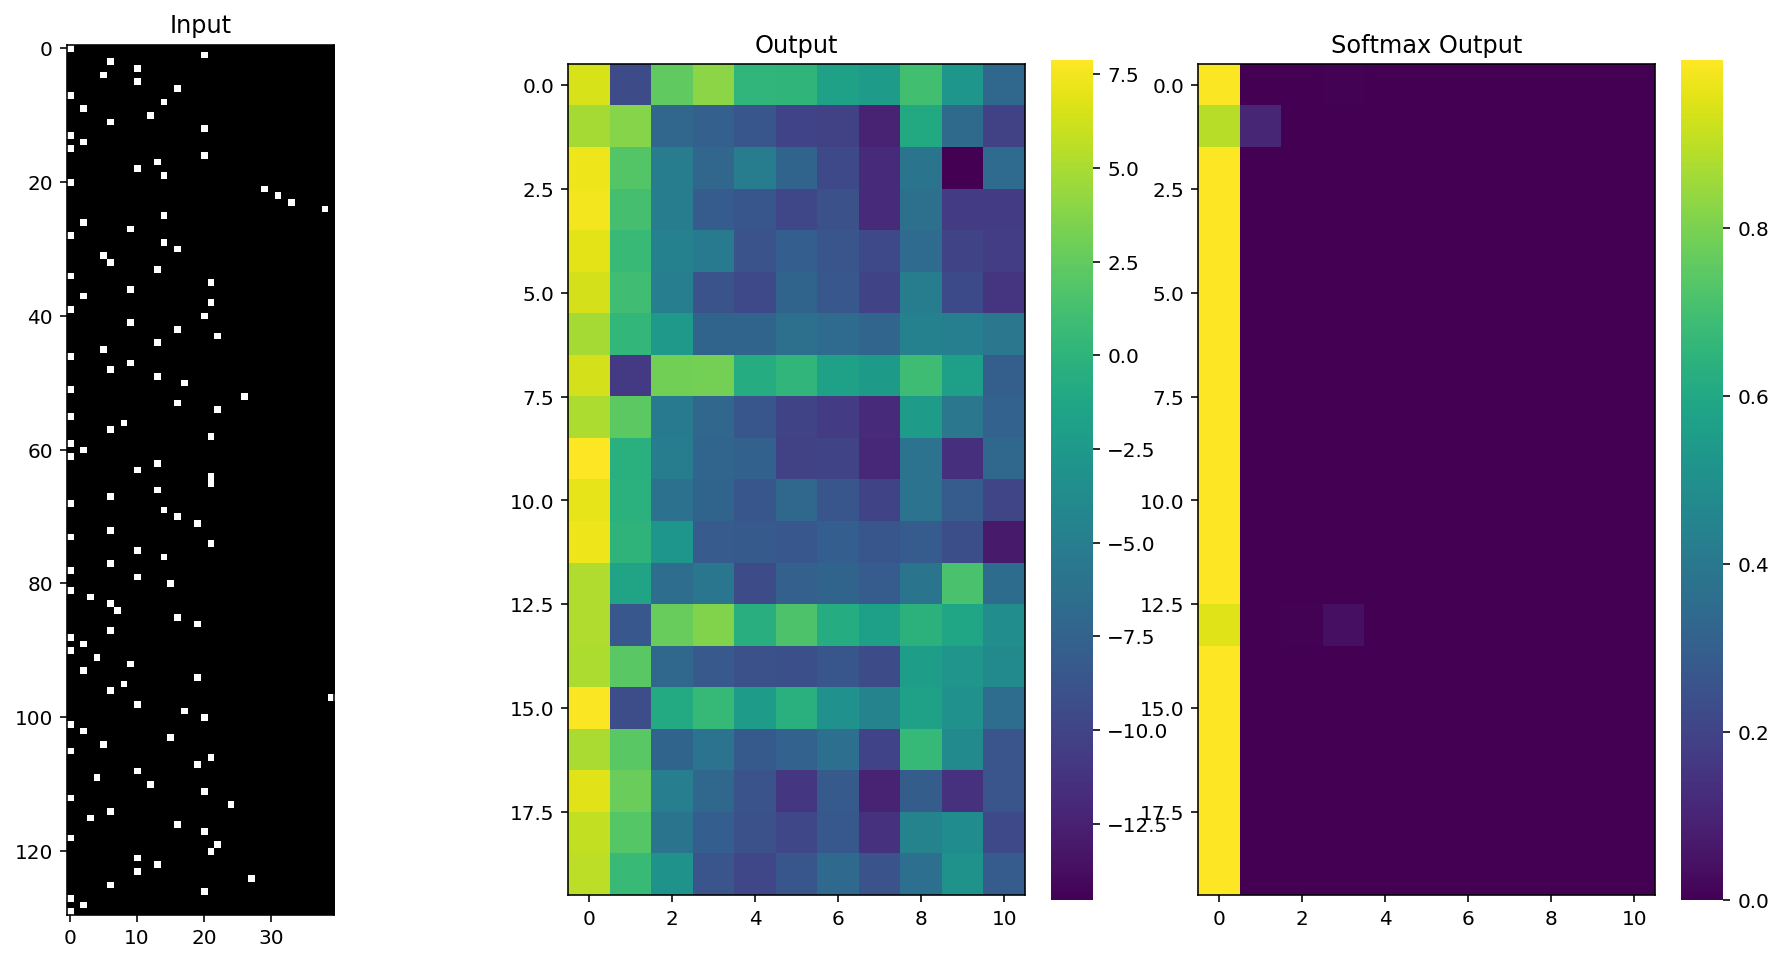

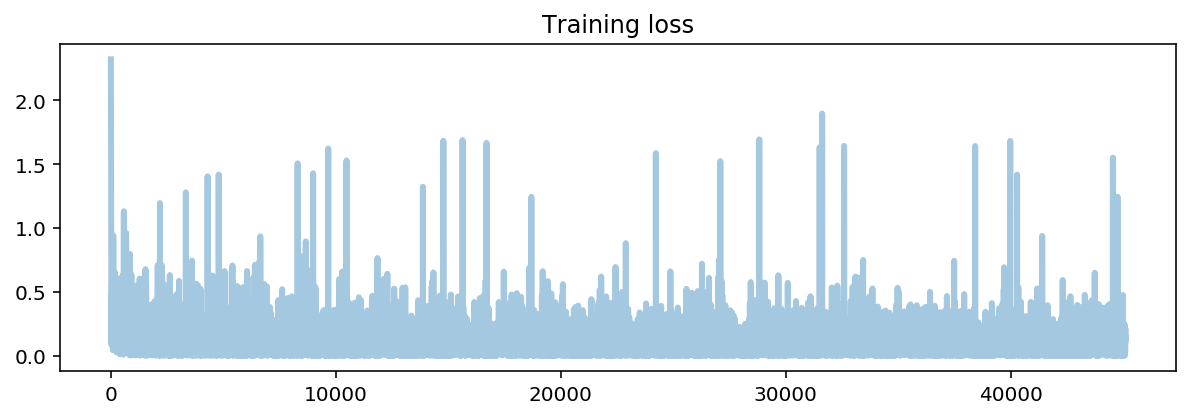

 seidio makes a slim 1,350mAh model that should help you get a little more time in before a charge.Tips and tricks webOS utilizes a slew of keyboard shortcuts try hitting option. the orange or gray Key  Sym  P to take a screenshot or option  Sym  R to reboot your device option  iCon Tap in the Launcher will allow you to delete an app or option  Sym  I in an open Card will give you stats on that process don't forget to add your mostused contacts to speed dial so, you can call your friends and family with a long press on the key that you've assigned copy and paste works just as you'd expect here  after selecting text shift  tap use a combo of Gesture area tap  a C V and X for select all copy paste and cut in weboS 2.0 it can be helpful to group cards by use  for instance we like to keep Voogle grouped behind our phone dialer, so our voicemail and phone are in one place creating your own alert tones is super easy as of version webOS 14.  just create a fold

Key: <nop>	Prec:  98.9%	Recall:

17574it [6:44:01,  1.22it/s]

In [ ]:
model.zero_grad()
egdt.reset_loss()

seq_length = 1000

for epoch_num in range(10):
    
    step = 0
    
    for file_ind, (file_name, source) in enumerate(tqdm(train_gen())):
        
        # at the begining of the file, reset hidden to zero
        egdt.init_hidden_(random=False)
            
        for source_ in batch_gen(seq_length, source):
            
            
            step += 1
            
            input_source, punctuation_target = extract_punc(source_, egdt.char2vec.chars, egdt.output_char2vec.chars)
            #print(len(input_source), len(punctuation_target))
            
            try:
                egdt.forward(input_source, punctuation_target)
                if step%1 == 0:
                    egdt.descent()
                    
            except KeyError:
                print(source)
                raise KeyError
            

            if step%500 == 499:
                clear_output(wait=True)
                print('Epoch {:d}'.format(epoch_num))

                egdt.softmax_()

                plot_progress(egdt.embeded[:130].data.numpy(), 
                              egdt.output[:20].data.numpy(), 
                              egdt.softmax[:20].data.numpy(),
                              egdt.losses)
                
                punctuation_output = egdt.output_chars()
                result = apply_punc(input_source, punctuation_output)
                
                # print(punctuation_output, punctuation_target)
                print(result + "\n")
                
                print_pc(punctuation_output, punctuation_target)
                
        # validation, ran once in a while. takes a munite to run.
        if file_ind%200 == 1999:
            print('Dev Set Performance {:d}'.format(epoch_num))


            validation_source = "".join([source for fn, source in validation_gen()])
            input_source, punctuation_target = extract_punc(validation_source, egdt.char2vec.chars, egdt.output_char2vec.chars)
            egdt.init_hidden_(random=False)
            egdt.forward(input_source, punctuation_target)
            egdt.softmax_()
            plot_progress(egdt.embeded[:130].data.numpy(), 
                          egdt.output[:20].data.numpy(), 
                          egdt.softmax[:20].data.numpy(),
                          egdt.losses)

            punctuation_output = egdt.output_chars()
            result = apply_punc(input_source, punctuation_output)

            # print(punctuation_output, punctuation_target)
            print(result + "\n")

            print_pc(punctuation_output, punctuation_target)

## Now use the network to generate text!

In [ ]:
egdt.save('./data/Gru_Engadget_1_layer_bi_narrow.tar')

In [ ]:
from ipywidgets import widgets
from IPython.display import display

**Note**: Again, using a zero initial state for the hidden state gives a much better result for the prediction.

In [ ]:
def predict_next(input_text, gen_length=None, temperature=0.05):
    
    if gen_length is None: 
        gen_length = len(input_text)
    
    clear_output(wait=True)
    #egdt = Engadget(model).init_hidden_(random=True)
    
    egdt.init_hidden_()
    egdt.next_(input_text)
    egdt.softmax_()
    output = egdt.output_chars()
    
    #print(output)
    result = apply_punc(input_text, output)
    print(result)
    
    plt.figure(figsize=(12, 9))
    plt.subplot(311)
    plt.title("Input")
    plt.imshow(egdt.embeded[:130].data.byte().numpy().T, cmap="Greys_r", interpolation="none")
    plt.subplot(312)
    plt.title("Output")
    plt.imshow(egdt.output[:130].data.byte().numpy().T, interpolation="none")
    plt.subplot(313)
    plt.title("Softmax")
    plt.imshow(egdt.softmax[:130].cpu().data.numpy().T, interpolation="none")
    plt.show()

predict_next("   this wont be a simple sentense it doesnt have puntuations\n\nim not sure", 200, 1)

In [ ]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    #print(text_input.value)
    predict_next(text_input.value, 2000, temperature=0.5)
    
text_input.on_submit(handle_submit)

The ge